# Introduction

### Problem Description

It will be written soon.

### Software Requirements

(tensorflow)

# General Preparations

### Import Statements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  # To make graphs prettier.

from sklearn.metrics import r2_score

import tensorflow as tf

Here `tensorflow` is preferred over more easy-to-read `keras`, because it allows forecasting several steps ahead without passing predictions as ground truth. In other words, there is a facility to train to forecast with a horizon. 

### Data Extraction and Exploratory Analysis

In [2]:
ser = pd.read_csv('series_with_seasonality.csv', sep='\t')['value']
ser.head()

0    1.7024
1    0.3600
2    0.0000
3    0.0000
4    0.2848
Name: value, dtype: float64

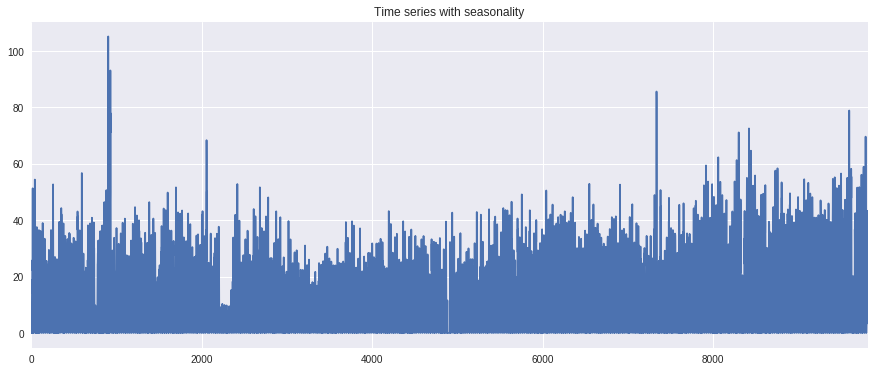

In [3]:
_ = ser.plot(figsize=(15, 6), grid=True,
             title='Time series with seasonality')

It is hard to study the series behavior from the above graph, so look at a small piece of it.

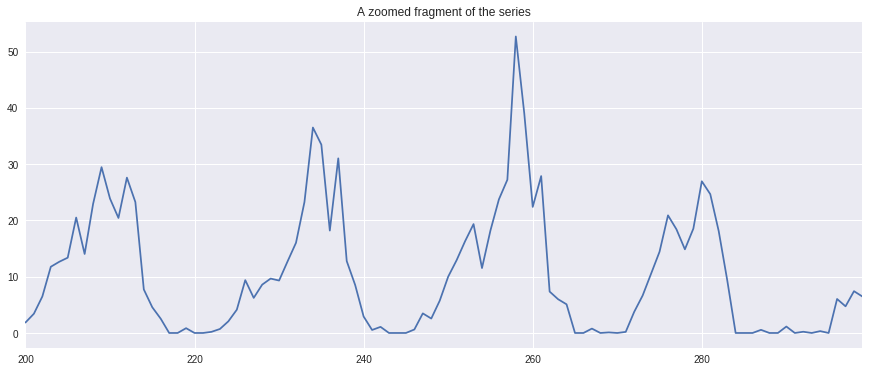

In [4]:
_ = ser[200:300].plot(figsize=(15, 6), grid=True,
                      title='A zoomed fragment of the series')

In [5]:
ser.describe()

count    9817.000000
mean       12.375714
std        12.806379
min         0.000000
25%         0.860800
50%         9.028800
75%        20.532800
max       105.168000
Name: value, dtype: float64

### Baseline model

What forecast quality can be achieved by a simple baseline model such as, say, moving average of a specific window size?

Below results of MA(24) model are shown, where 24 is period of seasonality of the series. One can try to use other window sizes — the higher they are, the less slowly predictions made for a long horizon converge to a constant.

In [6]:
window_size = 24

In [7]:
ma_preds = ser.shift().rolling(window=window_size, min_periods=1).mean()
ma_preds.iloc[0] = 0
ma_preds.head()

0    0.000000
1    1.702400
2    1.031200
3    0.687467
4    0.515600
Name: value, dtype: float64

In [8]:
r2_score(ser, ma_preds)

0.043940706000685004

Above score means that almost no variation of the series around its mean can be explained by MA(24). Actually, such variation is caused by seasonality and noise, because the series has no trend.

Local variations around local means are not explained at all too. Let us look at some examples.

In [9]:
r2_score(ser[-100:], ma_preds[-100:])

-0.038458145069518945

In [10]:
r2_score(ser[-1100:-1000], ma_preds[-1100:-1000])

-0.029080930736050004

Another important thing that should be noticed here, is that the above scores relate to multiple one-step-ahead forecasts. If there is a need to create a forecast with long horizon, MA(24) performs slightly poorer. To see this, split data to a "train" set (actually, MA(24) has no fitting) and a hold-out test set. 

In [11]:
horizon = 100
train_ratio = 0.75
train_test_frontier = int(round(train_ratio * len(ser.index), 0))

-0.10188688141676283

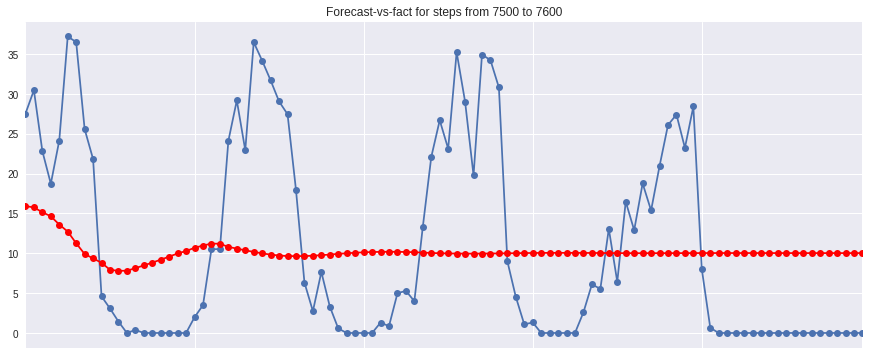

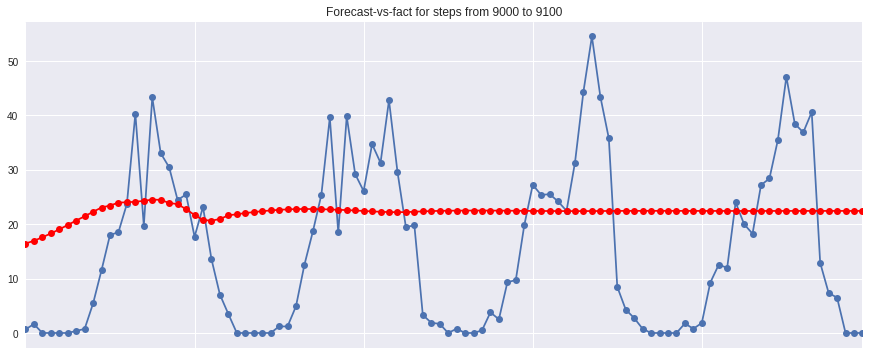

In [12]:
scores = []
for i in range(train_test_frontier, len(ser.index) - horizon):
    y_true = ser.iloc[i:(i + horizon)]
    y_hat = ser.iloc[(i - window_size):i].tolist()
    for j in range(horizon):
        y_hat.append(sum(y_hat[-window_size:]) / window_size)

    y_hat = y_hat[window_size:]
    score = r2_score(y_true, y_hat)
    scores.append(score)
    
    if i % 1500 == 0:
        fig = plt.figure(figsize=(15, 6))
        ax = fig.add_subplot(111)
        ax.set_title('Forecast-vs-fact for steps from {} to {}'.format(i, i + horizon))
        ax.set_xticklabels([])
        
        y_true.plot(ax=ax, marker='o')
        pd.Series(y_hat, index=y_true.index).plot(ax=ax, c='red', marker='o')

sum(scores) / len(scores)

Of course, negative values of $R^2$ scores are not a bug. As it can be seen, MA(24) predictions converge quite rapidly to a constant. If this constant is equal to mean of the corresponding slice from the true series, $R^2$ score is 0, because the model does not explain any variation around the mean. However, any constant that is not equal to the true mean, is worse than the true mean from MSE minimization point of view, and so $R^2$ coefficient of determination is even lower than 0, i.e. it is negative.

# Forecasting with LSTM

### Functions and Classes

In [13]:
def build_rnn(inputs, n_outputs, rnn_width, rnn_depth):
    """
    Defines architecture of an RNN.
    
    @type inputs: tensorflow.Tensor
    @type n_outputs: int
    @type rnn_width: int
    @type rnn_depth: int
    @return: tuple(tensorflow.Tensor)
    """
    basic_cell = tf.contrib.rnn.BasicLSTMCell(rnn_width)
    multi_cell = tf.contrib.rnn.MultiRNNCell([basic_cell for _ in range(rnn_depth)])
    
    batch_size = tf.shape(inputs)[0]
    initial_state = tf.identity(multi_cell.zero_state(batch_size, tf.float32),
                                name='initial_state')
    
    lstm_outputs, final_state = tf.nn.dynamic_rnn(multi_cell, inputs, dtype=tf.float32)
    final_state = tf.identity(final_state, name='final_state')
    
    preds = tf.contrib.layers.fully_connected(lstm_outputs, n_outputs,
                                              activation_fn=None)
    preds = tf.identity(preds, name='predictions')
    return preds, initial_state, final_state

In [14]:
def get_batches_for_lstm(ser, batch_size, horizon, n_lags, n_time_steps=1):
    """
    Converts time series to batches
    represented as data matrices.
    
    @type ser: pandas.Series
    @type batch_size: int
    @type horizon: int
    @type n_lags: int
    @type n_time_steps: int
    @return: list(tuple(numpy.ndarray))
    """
    df = ser.to_frame(name='curr_value')
    for i in range(1, n_lags + 1):
        df['lag_{}'.format(i)] = df['curr_value'].shift(i)
    for i in range(1, horizon + 1):
        df['ahead_{}'.format(i)] = df['curr_value'].shift(-i)
    n_batches = (len(ser) - horizon - n_lags) // batch_size
    df = df.iloc[n_lags:(n_batches*batch_size + n_lags), :]

    x_array = df.iloc[:, :-horizon].values.reshape((n_batches, -1, n_time_steps, n_lags + 1))
    y_array = df.iloc[:, -horizon:].values.reshape((n_batches, -1, n_time_steps, horizon))
    return list(zip(x_array, y_array))

In [15]:
class RunnerOfLSTM(object):
    """
    """
    # TODO: Fill above docstring.
    
    def __init__(self, horizon, n_lags, rnn_width, rnn_depth):
        """
        @type horizon: int
        @type n_lags: int
        @type rnn_width: int
        @type rnn_depth: int
        """
        self.horizon = horizon
        self.n_lags = n_lags
        self.rnn_width = rnn_width
        self.rnn_depth = rnn_depth
        
        self.sess = None
        self.state = None
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            # Define placeholders.
            self.inputs = tf.placeholder(tf.float32,
                                         shape=(None, None, self.n_lags + 1),
                                         name='inputs')
            self.targets = tf.placeholder(tf.float32,
                                          shape=(None, None, self.horizon),
                                          name='targets')
            self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')

            # Build neural network.
            self.preds, self.initial_state, self.final_state = \
                build_rnn(self.inputs, self.horizon, self.rnn_width, self.rnn_depth)

            # Set an optimizational problem.
            self.cost = tf.losses.mean_squared_error(self.targets, self.preds)
            optimizer = tf.train.AdamOptimizer(self.learning_rate)

            # Clip gradients.
            gradients = optimizer.compute_gradients(self.cost)
            capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var)
                                for grad, var in gradients]
            self.train_optim = optimizer.apply_gradients(capped_gradients)
            
    def _train(self, train_ser, batch_size, n_epochs, learn_rate, ckpt_path):
        """
        Trains LSTM and informs about training.
        Also can save trained model and
        its last state if `ckpt_path` is set.
        
        @type train_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type ckpt_path: str
        @return: None
        """
        batches = get_batches_for_lstm(train_ser, batch_size, self.horizon, self.n_lags)

        for epoch_cnt in range(n_epochs):
            # Reset state, because batches are started from the beginning of the series.
            state = self.sess.run(self.initial_state, {self.inputs: batches[0][0]})

            for batch_cnt, (x, y) in enumerate(batches):
                feed_dict = {self.inputs: x,
                             self.targets: y,
                             self.initial_state: state,
                             self.learning_rate: learn_rate}
                y_hat, state, train_loss, _ = self.sess.run([self.preds,
                                                             self.final_state,
                                                             self.cost,
                                                             self.train_optim],
                                                            feed_dict)
            if epoch_cnt % 5 == 0:
                print('Epoch {:>3}:    train_loss = {:.3f}'.format(epoch_cnt, train_loss))
                        
        self.state = state
        if ckpt_path is not None:
            np.save(ckpt_path + '.state', state)
            saver = tf.train.Saver()
            saver.save(self.sess, ckpt_path)

    def _test(self, test_ser):
        """
        Reports performance on hold-out test set
        as coefficient of determination.
        Also visualizes some predictions against
        the corresponding actual values.
        
        @type test_ser: pandas.Series
        @return: float
        """
        scores = []
        batches = get_batches_for_lstm(test_ser, 1, self.horizon, self.n_lags)
        for batch_cnt, (x, y) in enumerate(batches):
            y_hat, state = self.sess.run([self.preds, self.final_state],
                                         {self.inputs: x,
                                          self.initial_state: self.state})
            y_hat[y_hat < 0] = 0  # Obvious improvement.
            curr_score = r2_score(y[0][0], y_hat[0][0])
            scores.append(curr_score)

            if batch_cnt % 500 == 0:
                fig = plt.figure(figsize=(15, 6))
                ax = fig.add_subplot(111)
                start_step = train_test_frontier + batch_cnt
                ax.set_title('Forecast-vs-fact for steps from {} to {}'.format(
                    start_step, start_step + self.horizon))
                ax.set_xticklabels([])
                ax.grid(True)

                pd.Series(y[0][0]).plot(ax=ax, marker='o')
                pd.Series(y_hat[0][0]).plot(ax=ax, c='red', marker='o')
        
        return sum(scores) / len(scores)
        
    def run(self, train_ser, test_ser, batch_size, n_epochs, learn_rate,
            ckpt_path=None):
        """
        Trains LSTM model with a specified
        hyperparameters on `train_ser` and
        then evaluates its performance on
        `test_ser`.
        If `ckpt_path` is passed, the trained
        model is serialized as check-point
        files.
        
        @type train_ser: pandas.Series
        @type test_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type ckpt_path: str
        @return: float
        """
        with tf.Session(graph=self.graph) as self.sess:
            self.sess.run(tf.global_variables_initializer())
            self._train(train_ser, batch_size, n_epochs, learn_rate, ckpt_path)
            score = self._test(test_ser)
        return score

### Application

In [16]:
horizon = 100
n_lags = 24

rnn_width = 32
rnn_depth = 2

batch_size = 32
n_epochs = 100
learn_rate = 0.001

Epoch   0:    train_loss = 420.530
Epoch   5:    train_loss = 349.011
Epoch  10:    train_loss = 340.213
Epoch  15:    train_loss = 319.169
Epoch  20:    train_loss = 284.902
Epoch  25:    train_loss = 247.844
Epoch  30:    train_loss = 220.525
Epoch  35:    train_loss = 207.734
Epoch  40:    train_loss = 204.901
Epoch  45:    train_loss = 205.339
Epoch  50:    train_loss = 205.266
Epoch  55:    train_loss = 204.845
Epoch  60:    train_loss = 204.420
Epoch  65:    train_loss = 203.905
Epoch  70:    train_loss = 203.775
Epoch  75:    train_loss = 203.670
Epoch  80:    train_loss = 202.781
Epoch  85:    train_loss = 201.966
Epoch  90:    train_loss = 201.801
Epoch  95:    train_loss = 200.880


0.61889469406522268

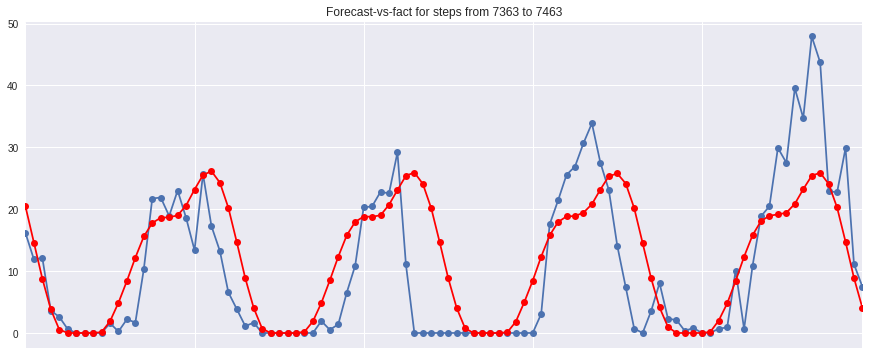

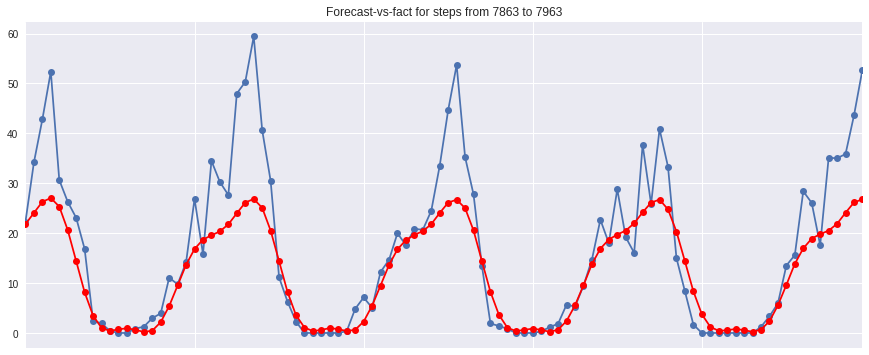

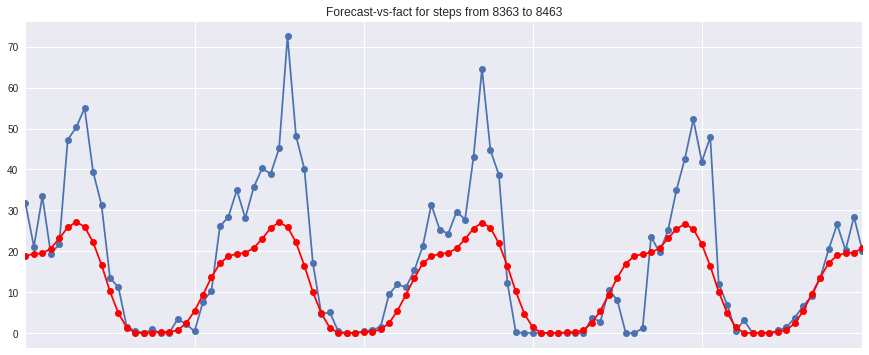

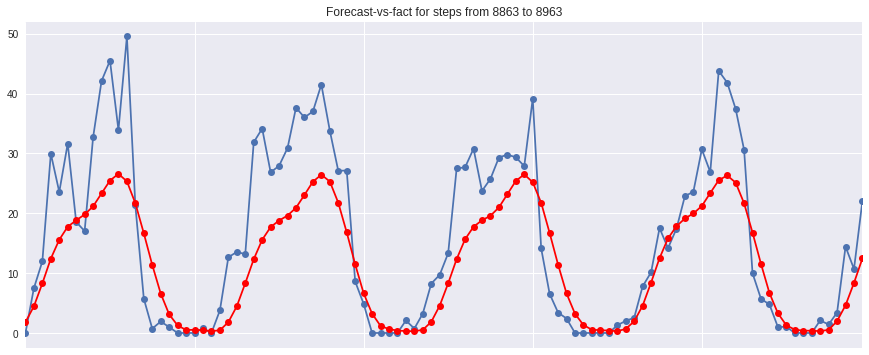

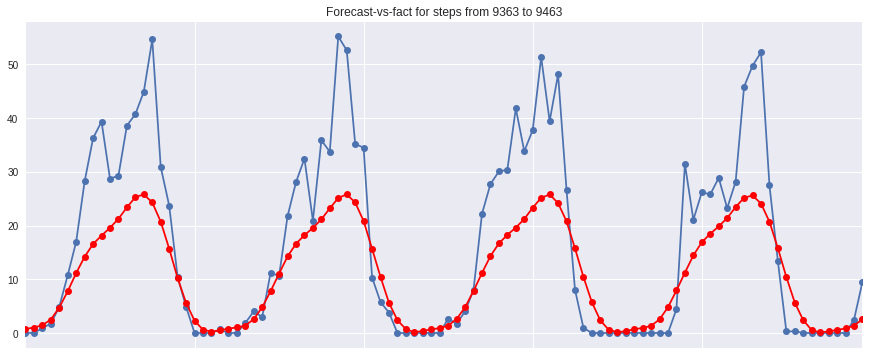

In [17]:
lstm_runner = RunnerOfLSTM(horizon, n_lags, rnn_width, rnn_depth)
score = lstm_runner.run(ser[:train_test_frontier], ser[train_test_frontier:],
                        batch_size, n_epochs, learn_rate,
                        ckpt_path='./trained_models/bare_lstm.ckpt')
score